# Transcription factor LTR enrichment analysis

This script will conduct an enrichment analysis of transcription factors in the MHC, identifying transcription factors whose binding sites are enriched in the MHC.

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
sys.path.insert(0, '..')

from utils.general import GenomeLookup
from utils.enrichment import HERVEnrichment
from utils.density import HERVDensity

We'll start by loading up and instance of the `HERVEnrichment` class, get the start/end coordinates of the MHC from the human gene annotation attribute, and load in the MHC region.

In [12]:
enrichment = HERVEnrichment()
mhc_start = min(enrichment.human_annotations.loc[(enrichment.human_annotations['name'] == 'MOG') & 
                                                 (enrichment.human_annotations['Chr'].str.contains('chr6$')), 'Start'])
mhc_end = max(enrichment.human_annotations.loc[(enrichment.human_annotations['name'] == 'COL11A2') & 
                                               (enrichment.human_annotations['Chr'].str.contains('chr6$')), 'End'])
enrichment.loadRegion(mhc_start, mhc_end, chrom = 6)

Then we can run a transcription factor enrichment analysis.

In [15]:
mhc_enr = enrichment.TFEnrichmentAnalysis()

We can run the `TFEnrichmentPlot()` function to generate a bubble plot of the results.

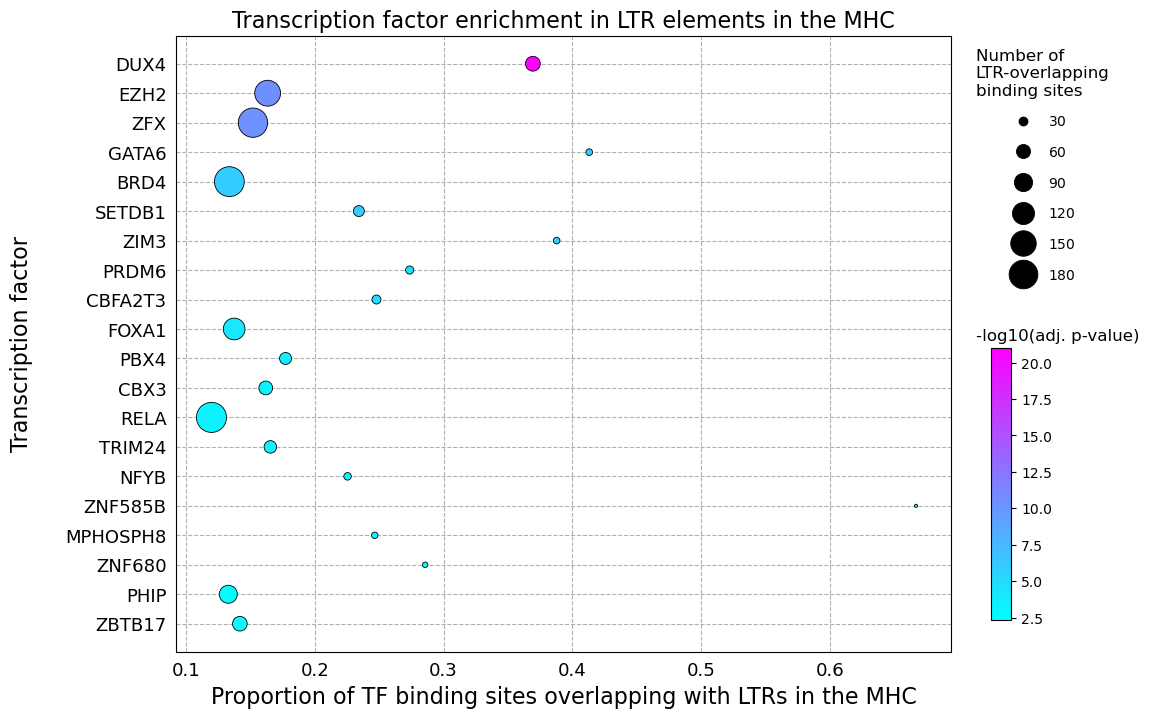

In [31]:
enrichment.TFEnrichmentPlot(mhc_enr, path = 'figures/fig1b.png',
                            xlab = 'Proportion of TF binding sites overlapping with LTRs in the MHC',
                            title = 'Transcription factor enrichment in LTR elements in the MHC')

Then we can run an LTR superfamily enrichment analysis for the top two transcription factors: EZH2 and DUX4. This function will identify LTR superfamilies in which each transcription factor's binding sites are overrepresented.

In [17]:
mhc_EZH2_LTR_family_enr = enrichment.TFHERVFamilyEnrichmentAnalysis(TF = 'EZH2')
mhc_EZH2_LTR_family_enr

,num_all_peaks_in_family,num_TF_peaks_in_family,p,adj_p
ERVK,509.0,10.0,0.039719,0.173545
ERVL?,32.0,2.0,0.043386,0.173545
ERVL-MaLR,3530.0,45.0,0.070220,0.187253
Gypsy,324.0,5.0,0.247444,0.494888
ERVL,4196.0,43.0,0.572518,0.817551
LTR,103.0,1.0,0.660137,0.817551
Gypsy?,240.0,2.0,0.715358,0.817551
ERV1,5796.0,45.0,0.996053,0.996053


In [18]:
mhc_DUX4_LTR_family_enr = enrichment.TFHERVFamilyEnrichmentAnalysis(TF = 'DUX4')
mhc_DUX4_LTR_family_enr

,num_all_peaks_in_family,num_TF_peaks_in_family,p,adj_p
ERVL-MaLR,3530.0,37.0,1.207954e-08,9.663628e-08
ERVL?,32.0,1.0,1.320927e-01,5.283708e-01
ERVK,509.0,3.0,3.908861e-01,1.000000e+00
ERVL,4196.0,14.0,9.197401e-01,1.000000e+00
ERV1,5796.0,10.0,9.999937e-01,1.000000e+00
Gypsy,324.0,0.0,1.000000e+00,1.000000e+00
Gypsy?,240.0,0.0,1.000000e+00,1.000000e+00
LTR,103.0,0.0,1.000000e+00,1.000000e+00


Now let's initialise an instance of the `HERVDensity` class. and load in the MHC region. We'll use this class to sample random regions of the genome that are the same size as the MHC.

In [19]:
density = HERVDensity()
density.loadRegion(mhc_start, mhc_end, chrom = 6)

First we'll look for regions of the genome with similar LTR compositions to the MHC. Let's pull out the number of LTR elements in each superfamily present in the MHC.

In [20]:
# get the LTR family compositions of the MHC

LTR_family_counts = density.LTRs_in_region['family'].value_counts()

Then we'll sample 100000 random regions of the genome.

In [21]:
# sample regions from the genome

MC_results = density.monteCarlo(n = 100000, track_families = True, state = 123)

We'll calculate the similarity between each sampled region and the MHC using an $L^2$ norm and get the 50 most similar regions. We'll also grab 50 random regions to establish a comparative baseline.

In [22]:
# calculate distance between each region and the MHC in terms of LTR families

norms = np.linalg.norm(LTR_family_counts.to_numpy() - MC_results['LTR_family_counts'], axis = 1, ord = 2)
similar_LTR_family_regions = MC_results['regions'][norms.argsort()[:50]]
np.random.seed(123)
random_regions_idx = np.random.choice(len(MC_results['regions']), size = 50, replace = False)
random_regions = MC_results['regions'][random_regions_idx]

Let's print the LTR superfamily counts of the 10 most similar regions to the MHC, and the first 10 random regions we sampled.

In [23]:
# print 10 most similar sampled regions to the MHC in terms of LTR composition

print(LTR_family_counts)
print(MC_results['LTR_family_counts'][norms.argsort()[:10]])
print(MC_results['LTR_family_counts'][random_regions_idx[:10]])

ERVL-MaLR    327
ERV1         288
ERVL         270
ERVK          49
Gypsy         16
ERVL?          7
Gypsy?         7
LTR            4
Name: family, dtype: int64
[[327 288 270  49  16   7   7   4]
 [327 288 270  49  16   7   7   4]
 [325 288 270  48  16   7   7   4]
 [326 281 267  48  16   7   7   4]
 [327 282 263  50  16   7   7   4]
 [332 290 278  44  16   7   7   4]
 [331 290 279  44  16   7   6   4]
 [332 291 278  44  15   4   6   4]
 [328 282 259  50  16   7   7   4]
 [331 290 281  44  13   7   6   4]]
[[414 172 234  10  32   2  15   1]
 [552 237 311  28  24   5   5   9]
 [450 181 258  10  28   1   6   6]
 [695 176 234   3  20   0   5   6]
 [338 171 151  22  18   5  19   7]
 [398 131 170   1  44   2   9   9]
 [587 216 230   7  17   1   5   3]
 [485 194 224  10  22   5   8   4]
 [346 197 150  11  13   5   5   3]
 [361 175 164   9  20   0  14   3]]


Looks like the similarity calculations worked well - the 10 most similar regions to the MHC in terms of LTR superfamily composition are indeed very similar - the two most similar regions match the MHC perfectly.

Let's loop over the MHC-similar regions and run the TF enrichment analysis, using only LTRs from superfamilies that are present in the MHC.

In [24]:
# get TF enrichment profiles in similar regions

similar_region_enrichment_results = []
for start, end, chrom in similar_LTR_family_regions:
    enrichment.loadRegion(start, end, chrom)
    enrichment.LTRs_in_region = enrichment.LTRs_in_region[enrichment.LTRs_in_region['family'].isin(LTR_family_counts.index)]
    res = enrichment.TFEnrichmentAnalysis()
    similar_region_enrichment_results.append(res)
    
sim_region_TF_p_values = {}
for res in similar_region_enrichment_results:
    for TF in res.index:
        if TF not in sim_region_TF_p_values:
            sim_region_TF_p_values[TF] = []
        sim_region_TF_p_values[TF].append(res.loc[TF, 'adj_p'])
        
# calculate harmonic mean of enrichment p-values across MHC-similar regions
sim_region_p_value_df = pd.DataFrame([(TF, 1 / np.mean([1/val for val in p])) for TF, p in sim_region_TF_p_values.items()], 
                                     columns = ['TF', 'mean_p'])
sim_region_p_value_df = sim_region_p_value_df.set_index('TF')
top_20_TFs_similar_regions = sim_region_p_value_df.sort_values('mean_p').iloc[:20].index

No TFs have binding sites in this region.
No TFs have binding sites in this region.


Looks like 2 of the 50 sampled regions have no transcription factor binding sites (according the ReMap dataset).

Now we'll do the same for random regions, only this time we'll run the enrichment analysis using LTRs from all superfamilies.

In [25]:
# get TF enrichment profiles in random regions

random_region_enrichment_results = []
for start, end, chrom in random_regions:
    enrichment.loadRegion(start, end, chrom)
    res = enrichment.TFEnrichmentAnalysis()
    random_region_enrichment_results.append(res)
    
# get set of p-values for each gene

random_region_TF_p_values = {}
for res in random_region_enrichment_results:
    for TF in res.index:
        if TF not in random_region_TF_p_values:
            random_region_TF_p_values[TF] = []
        random_region_TF_p_values[TF].append(res.loc[TF, 'adj_p'])
        
random_region_p_value_df = pd.DataFrame([(gene, 1 / np.mean([1/val for val in p])) for gene, p in random_region_TF_p_values.items()], 
                                        columns = ['TF', 'mean_p'])
random_region_p_value_df = random_region_p_value_df.set_index('TF')
top_20_TFs_random_regions = random_region_p_value_df.sort_values('mean_p').iloc[:20].index

No TFs have binding sites in this region.
No TFs have binding sites in this region.
No TFs have binding sites in this region.


Let's get the top 20 most LTR-enriched transcription factors in the MHC and merge data for those transcription factors with the results from sampled regions.

In [26]:
top_20_mhc_TFs = mhc_enr.iloc[:20]

In [30]:
top_20_mhc_TFs_merged = top_20_mhc_TFs.merge(
    sim_region_p_value_df, 
    left_index = True, 
    right_index = True, 
    how = 'left', 
    suffixes = ['', '_similar_regions']).merge(
    random_region_p_value_df,
    left_index = True, 
    right_index = True, 
    how = 'left', 
    suffixes = ['', '_random_regions'])

top_20_mhc_TFs_merged = top_20_mhc_TFs_merged.drop('p', axis = 1)
props = top_20_mhc_TFs_merged['num_TF_peaks_in_HERVs'] / top_20_mhc_TFs_merged['num_TF_peaks']
top_20_mhc_TFs_merged.insert(2, 'proportion_BS_in_HERVs', props)

top_20_mhc_TFs_merged

,num_TF_peaks,num_TF_peaks_in_HERVs,proportion_BS_in_HERVs,adj_p,mean_p,mean_p_random_regions
DUX4,176.0,65.0,0.369318,9.522232e-22,6.043950e-36,3.358171e-56
EZH2,936.0,153.0,0.163462,3.021582e-11,4.037227e-29,1.682880e-49
ZFX,1223.0,186.0,0.152085,4.522802e-11,3.399211e-56,3.970321e-56
GATA6,46.0,19.0,0.413043,7.459843e-07,2.004935e-01,7.026209e-06
BRD4,1428.0,191.0,0.133754,7.459843e-07,1.524880e-27,6.624941e-13
SETDB1,175.0,41.0,0.234286,7.459843e-07,8.825103e-33,4.436914e-34
ZIM3,49.0,19.0,0.387755,1.513029e-06,1.878842e-02,6.975044e-02
PRDM6,95.0,26.0,0.273684,1.311062e-05,9.966781e-01,9.542736e-01
CBFA2T3,121.0,30.0,0.247934,1.440445e-05,4.175844e-05,8.188259e-03
FOXA1,851.0,117.0,0.137485,8.747718e-05,1.087048e-03,3.258355e-05
